<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


import time 
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)


import warnings
warnings.filterwarnings("ignore")

SEED = 42


In [2]:
try:
    df = pd.read_csv(
        '/Users/egor/Desktop/Practicum/Спринт 11/Projec Taxi orders preds/taxi.csv',
        index_col = ['datetime'],
        parse_dates = [0]
    )
except:
    df = pd.read_csv(
        '/datasets/taxi.csv',
        index_col = ['datetime'],
        parse_dates = [0]
    )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sample(5)

,num_orders
datetime,
2018-08-25 05:10:00,24
2018-08-16 08:30:00,4
2018-08-31 08:10:00,52
2018-04-20 16:20:00,20
2018-05-09 21:20:00,6


In [5]:
# отсортируем индексы и сделаем ресмплирование данных
df = df.sort_index()
df = df.resample('1H').sum()

print(f'Data is monotonic: {df.index.is_monotonic}')

# найдем временной интервал 
print(
    f'\nTime period: \n{df.index.min()} - {df.index.max()}'
)


Data is monotonic: True

Time period: 
2018-03-01 00:00:00 - 2018-08-31 23:00:00


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

**Вывод**

- Данные загружены корректно, пропуски отсутствуют
- Датафрейм отсортирован по времени
- Сделано ресемплирование данных исходя из поставленной задачи - 1H

## Анализ

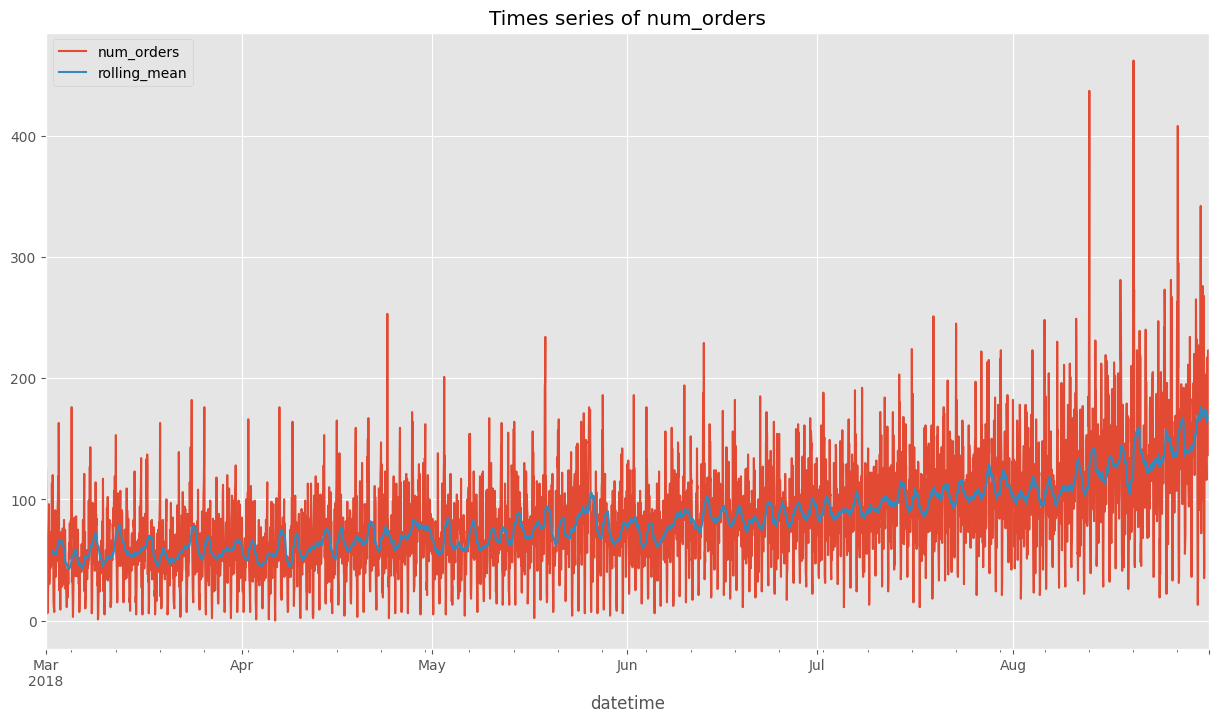

In [7]:
def time_series_plot(
            data: pd.Series,
            rolling: int
            ):
    new_df = pd.DataFrame(
        {
            data.name: data,
            'rolling_mean': data.rolling(rolling).mean()
        }
    )

    plt.style.use('ggplot')
    new_df.plot(figsize=(15, 8))
    plt.title(f'Times series of {data.name}')

time_series_plot(df.num_orders, 24)

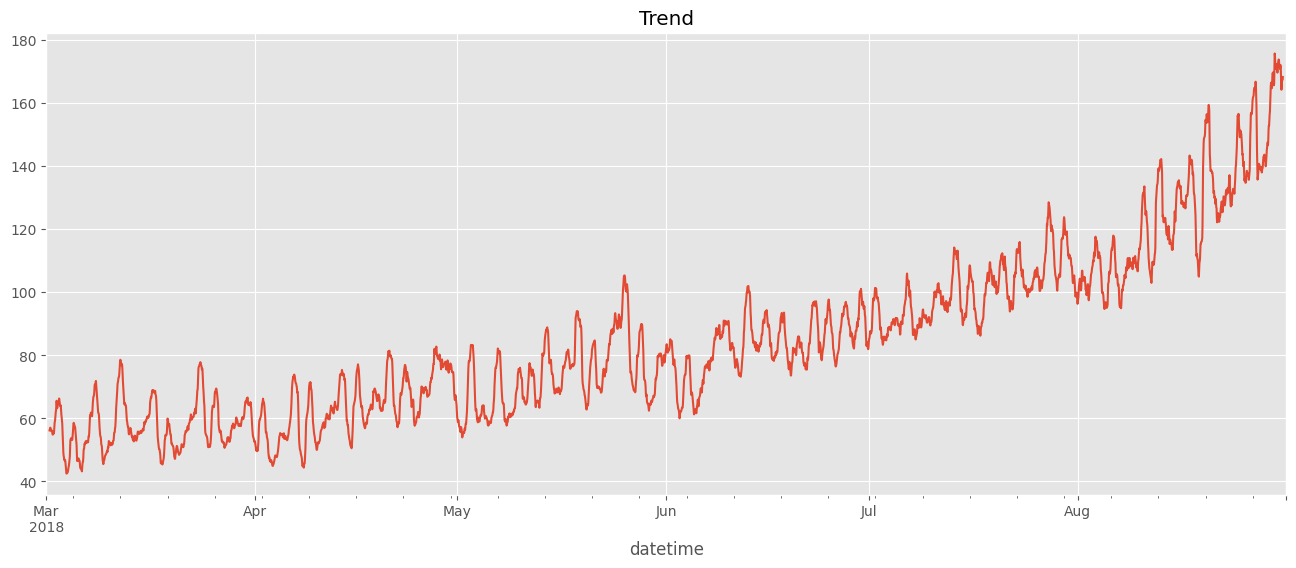

In [8]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df)
plt.figure(figsize=(16, 6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

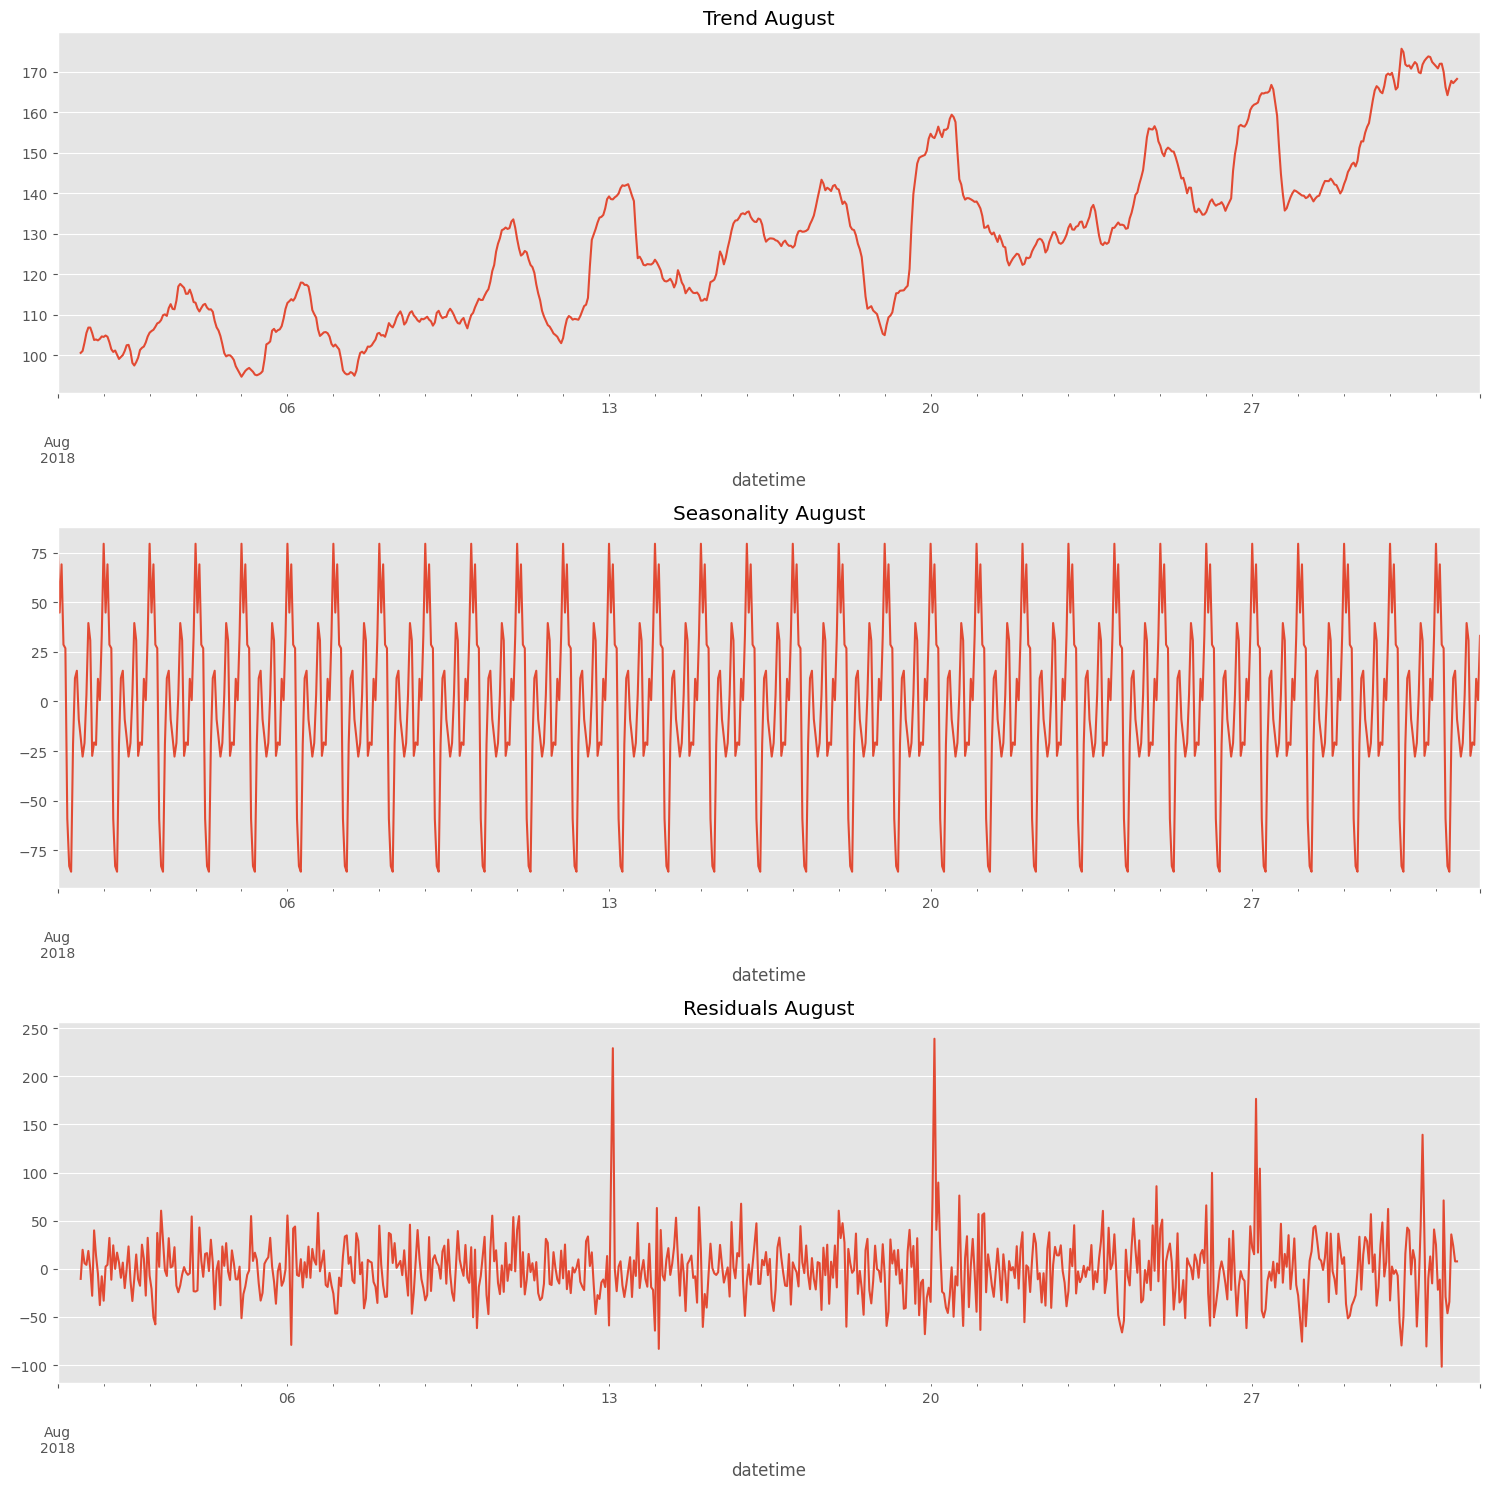

In [9]:
decomposed_month = seasonal_decompose(df['2018-08':'2018-08'])

plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed_month.trend.plot(ax=plt.gca())
plt.title('Trend August')

plt.subplot(312)
decomposed_month.seasonal.plot(ax=plt.gca())
plt.title('Seasonality August')

plt.subplot(313)
decomposed_month.resid.plot(ax=plt.gca())
plt.title('Residuals August')
plt.tight_layout()

In [10]:
def make_df_with_features(
    data: pd.DataFrame,
    max_lag: int,
    rolling_mean_size: int,
    column: str
):
    new_df = data.copy()
    new_df.name = column
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek

    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df[column].shift(lag)

    new_df['rolling_mean'] = (
        new_df[column]
        .shift()
        .rolling(rolling_mean_size)
        .mean()
    )

    return new_df


df_with_lags = make_df_with_features(
    df,
    24,
    2,
    'num_orders'
)

df_with_lags.sample(5)


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-07 16:00:00,99,16,1,111.0,74.0,100.0,115.0,71.0,99.0,120.0,...,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,92.5
2018-08-30 05:00:00,56,5,3,186.0,193.0,232.0,217.0,216.0,265.0,177.0,...,135.0,167.0,179.0,183.0,143.0,163.0,60.0,36.0,55.0,189.5
2018-08-19 07:00:00,49,7,6,26.0,73.0,143.0,169.0,134.0,93.0,179.0,...,146.0,113.0,44.0,86.0,115.0,117.0,178.0,108.0,41.0,49.5
2018-06-11 20:00:00,60,20,0,62.0,51.0,79.0,79.0,69.0,56.0,68.0,...,101.0,116.0,113.0,124.0,152.0,104.0,66.0,84.0,50.0,56.5
2018-06-01 04:00:00,65,4,4,132.0,111.0,77.0,118.0,129.0,93.0,107.0,...,65.0,88.0,73.0,91.0,71.0,17.0,6.0,48.0,142.0,121.5


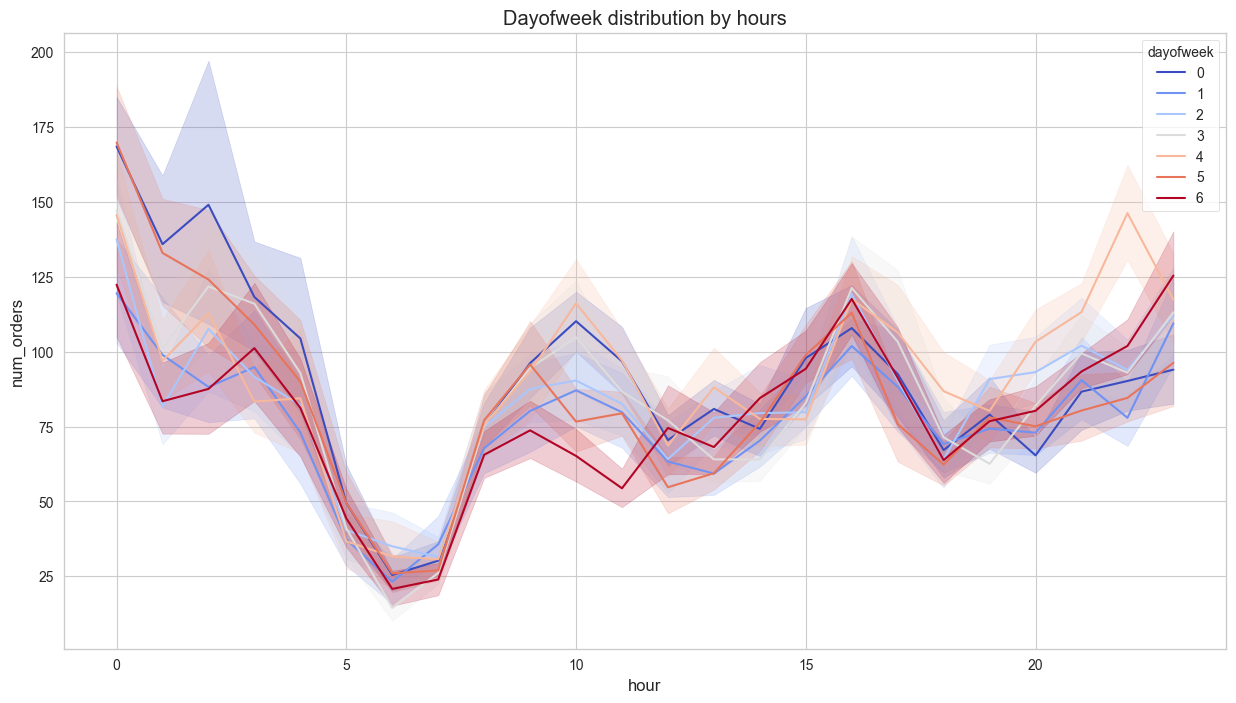

In [11]:
sns.set_style('whitegrid')
ax, fig = plt.subplots(figsize = (15, 8))
ax = sns.lineplot(
    data = df_with_lags,
    y = df_with_lags.num_orders,
    x = df_with_lags.hour,
    hue = df_with_lags.dayofweek,
    palette = 'coolwarm',
)
plt.title('Dayofweek distribution by hours');

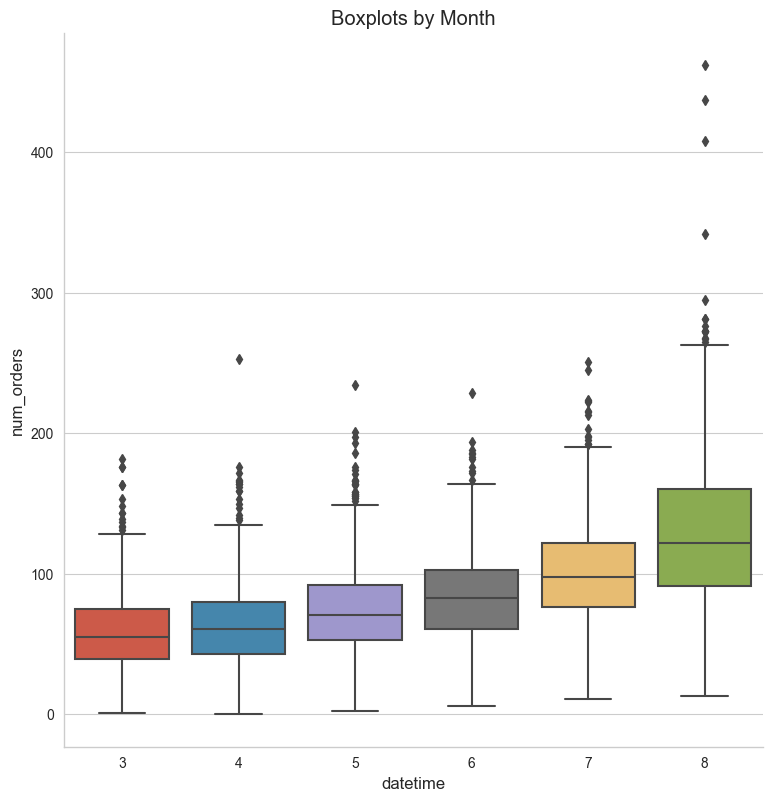

In [12]:
sns.catplot(
    data=df_with_lags,
    x=df_with_lags.index.month, 
    y=df_with_lags.num_orders,
    kind = 'box',
)
plt.title('Boxplots by Month' )
plt.gcf().set_size_inches(8, 8)

**Вывод:**
- В данных наблюдается растущий тренд
- Данные содержат выбросы
- Присутствует сезонность (по дням, часам)
- Были добавлены новые признаки (lag_(range 1 - 24), hour, day of week)

## Обучение

In [13]:
train, test = train_test_split(
    df_with_lags,
    shuffle = False,
    test_size = 0.1,
    random_state = SEED
)

train = train.dropna()

X_train = train.drop(['num_orders'], axis = 1).copy()
y_train = train['num_orders'].copy()

X_test = test.drop(['num_orders'], axis = 1).copy()
y_test = test['num_orders'].copy()

**LinearRegression**

In [14]:
clf_lr = LinearRegression()
lr_params = {'fit_intercept': [True, False]}

SPLITS = TimeSeriesSplit(n_splits = 3)

grid_lr = GridSearchCV(
    clf_lr,
    param_grid = lr_params,
    cv = SPLITS,
    scoring = 'neg_mean_squared_error',
    verbose = 1,
    n_jobs = -1
)

grid_lr.fit(X_train, y_train)

lr_train_preds = grid_lr.best_estimator_.predict(X_train)
lr_train_time = grid_lr.refit_time_
lr_train_rmse = abs(grid_lr.best_score_) ** 0.5

print(
    'Best model:', grid_lr.best_estimator_,
    '\nTraining time:', lr_train_time,
    '\nLR RMSE train score:', lr_train_rmse
)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best model: LinearRegression(fit_intercept=False) 
Training time: 0.015282154083251953 
LR RMSE train score: 25.841144205760095


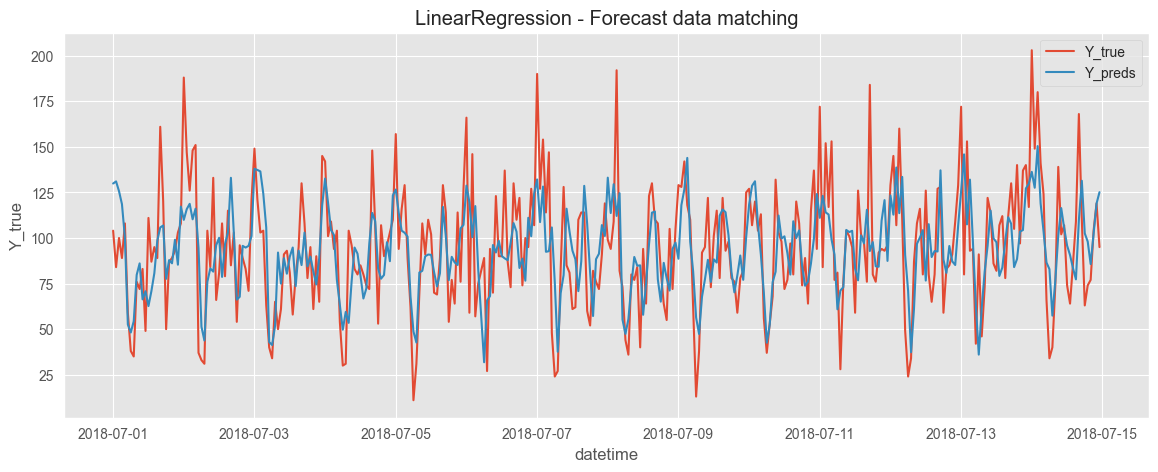

In [15]:
lr_train_data = pd.DataFrame(
    {
        'Y_true': y_train,
        'Y_preds': lr_train_preds
    }
)

lr_train_july = lr_train_data['2018-07-01':'2018-07-14']
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(
    x=lr_train_july.index, 
    y=lr_train_july['Y_true'], 
    label='Y_true'
)
sns.lineplot(
    x=lr_train_july.index, 
    y=lr_train_july['Y_preds'], 
    label='Y_preds'
)
plt.title('LinearRegression - Forecast data matching');

**RandomForestRegressor**

In [16]:
clf_rf = RandomForestRegressor(random_state=SEED)
rf_params = {'n_estimators': [10, 50, 100],
             'max_depth': [3, 5, 7, 9]}
grid_rf = GridSearchCV(
    clf_rf,
    param_grid = rf_params,
    cv = SPLITS,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1, 
    verbose = 1
)

grid_rf.fit(X_train, y_train)
rf_train_time = grid_rf.refit_time_
rf_train_preds = grid_rf.best_estimator_.predict(X_train)
rf_train_rmse = abs(grid_rf.best_score_) ** 0.5

print(
    'Best model:', grid_rf.best_estimator_,
    '\nRF training time:', rf_train_time,
    '\nRF RMSE train score:', rf_train_rmse
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best model: RandomForestRegressor(max_depth=9, n_estimators=50, random_state=42) 
RF training time: 1.4145948886871338 
RF RMSE train score: 16.115018084733794


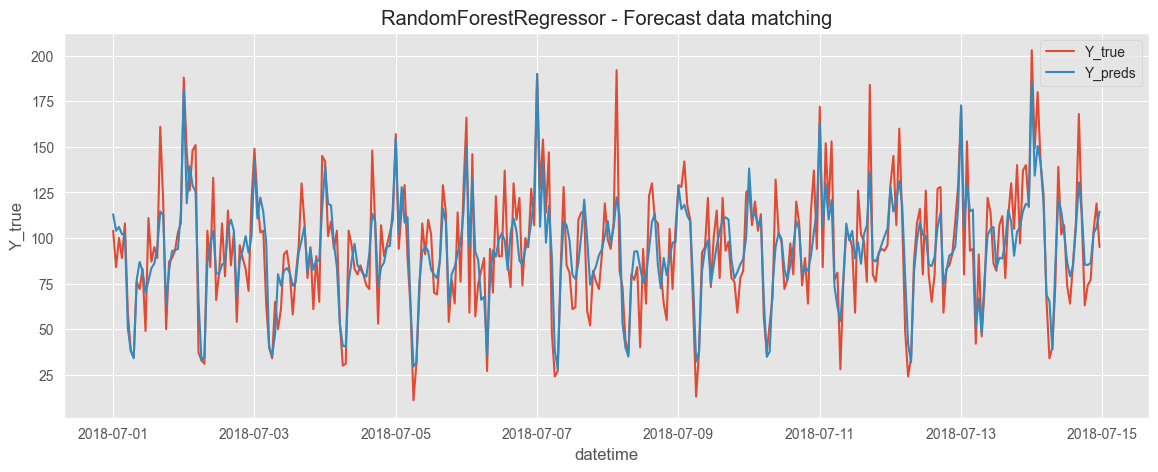

In [17]:
rf_train_data = pd.DataFrame(
    {
        'Y_true': y_train,
        'Y_preds': rf_train_preds
    }
)

rf_train_data_july = rf_train_data['2018-07-01':'2018-07-14']
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(
    x=rf_train_data_july.index, 
    y=rf_train_data_july['Y_true'], 
    label='Y_true'
)
sns.lineplot(
    x=rf_train_data_july.index, 
    y=rf_train_data_july['Y_preds'], 
    label='Y_preds'
)
plt.title('RandomForestRegressor - Forecast data matching');

**CatBoostRegressor**

In [18]:
clf_cat = CatBoostRegressor(
    random_state=SEED, 
    loss_function = 'RMSE', 
    verbose = False
)

cat_params = {
    'depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

cat_grid = GridSearchCV(
    estimator = clf_cat, 
    param_grid = cat_params,
    cv = SPLITS,
    verbose = 1,
    n_jobs= -1
)
cat_grid.fit(X_train, y_train)
cat_train_time = cat_grid.refit_time_
cat_train_preds = cat_grid.best_estimator_.predict(X_train)
cat_train_rmse = abs(cat_grid.best_score_) ** 0.5

print(
    'Best model:', cat_grid.best_estimator_,
    '\nCat training time:', cat_train_time,
    'Cat RMSE train:', cat_train_rmse
)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best model: <catboost.core.CatBoostRegressor object at 0x7fa7119b55b0> 
Cat training time: 0.20998191833496094 Cat RMSE train: 20.566149530674032


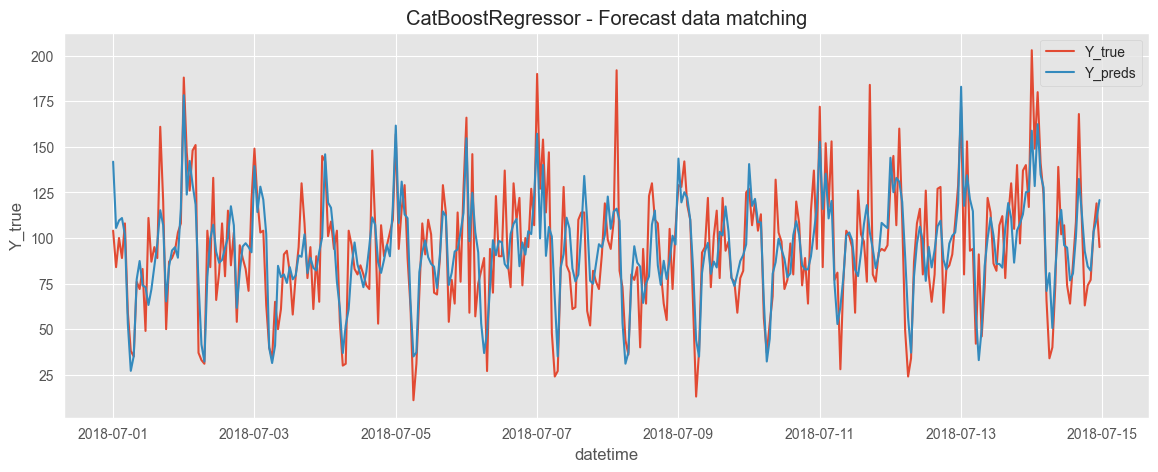

In [19]:
cat_train_data = pd.DataFrame(
    {
        'Y_true': y_train,
        'Y_preds': cat_train_preds
    }
)

cat_train_data_july = cat_train_data['2018-07-01':'2018-07-14']
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(
    x=cat_train_data_july.index, 
    y=cat_train_data_july['Y_true'], 
    label='Y_true'
)
sns.lineplot(
    x=cat_train_data_july.index, 
    y=cat_train_data_july['Y_preds'], 
    label='Y_preds'
)
plt.title('CatBoostRegressor - Forecast data matching');

**LGBMRegressor**

In [20]:
lgb_clf = LGBMRegressor(random_state=SEED)
lgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9, 12],
    'n_estimators': [50, 100, 200]
}


lgb_grid = GridSearchCV(
    estimator = lgb_clf,
    param_grid = lgb_params,
    cv = SPLITS,
    n_jobs= -1,
    verbose = 1
)

lgb_grid.fit(X_train, y_train)
lgb_training_time = lgb_grid.refit_time_
lgb_train_preds = lgb_grid.best_estimator_.predict(X_train)
lgb_train_rmse = abs(lgb_grid.best_score_) ** 0.5

print(
    'Best estimator:', lgb_grid.best_estimator_,
    '\nLGB training time:', lgb_training_time,
    '\nLGB RMSE train score:', lgb_train_rmse
)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best estimator: LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
              random_state=42) 
LGB training time: 0.1281740665435791 
LGB RMSE train score: 15.857132026101937


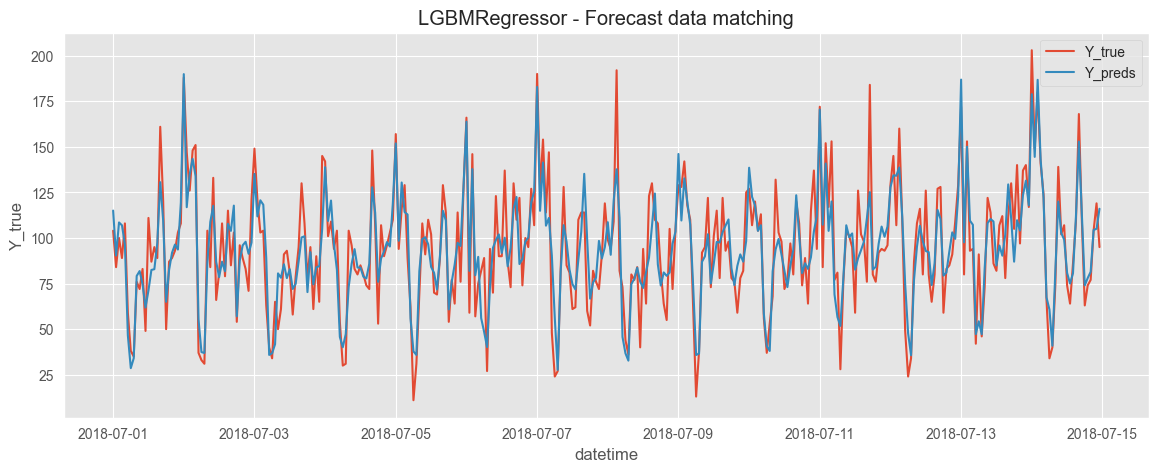

In [21]:
lgb_train_data = pd.DataFrame(
    {
        'Y_true': y_train,
        'Y_preds': lgb_train_preds
    }
)

lgb_train_data_july = lgb_train_data['2018-07-01':'2018-07-14']
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(
    x=lgb_train_data_july.index, 
    y=lgb_train_data_july['Y_true'], 
    label='Y_true'
)
sns.lineplot(
    x=lgb_train_data_july.index, 
    y=lgb_train_data_july['Y_preds'], 
    label='Y_preds'
)
plt.title('LGBMRegressor - Forecast data matching');

**Вывод:**

Лучшая модель на этапе train:
- LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,random_state=42) 
- Время обучения: 0.467 sec.
- RMSE train: 15.85

## Тестирование

In [22]:
# LinearRegression test
lr_test_preds = grid_lr.best_estimator_.predict(X_test)
lr_test_rmse = abs(mean_squared_error(y_test, lr_test_preds) ** 0.5)

# RandomForest test
rf_test_preds = grid_rf.best_estimator_.predict(X_test)
rf_test_rmse = abs(mean_squared_error(y_test, rf_test_preds) ** 0.5)

# CatBoost test
cat_test_preds = cat_grid.best_estimator_.predict(X_test)
cat_test_rmse = abs(mean_squared_error(y_test, cat_test_preds) ** 0.5)

# LGBM test
lgb_test_preds = lgb_grid.best_estimator_.predict(X_test)
lgb_test_rmse = abs(mean_squared_error(y_test, lgb_test_preds) ** 0.5)

In [23]:
model_train_time = [
    lr_train_time,
    rf_train_time,
    cat_train_time,
    lgb_training_time
]

model_train_rmse = [
    lr_train_rmse,
    rf_train_rmse,
    cat_train_rmse,
    lgb_train_rmse
]

models_test_rmse = [
    lr_test_rmse,
    rf_test_rmse,
    cat_test_rmse,
    lgb_test_rmse
]

models_result = pd.DataFrame(
    {
        'Training time': model_train_time,
        'RMSE (train)': model_train_rmse,
        'RMSE (test)': models_test_rmse
    },
    index=[
        'LinearRegression',
        'RandomForestRegressor',
        'CatBoostRegressor',
        'LGBMRegressor'
    ]
)

models_result

,Training time,RMSE (train),RMSE (test)
LinearRegression,0.015282,25.841144,45.192221
RandomForestRegressor,1.414595,16.115018,44.940660
CatBoostRegressor,0.209982,20.566150,43.508594
LGBMRegressor,0.128174,15.857132,41.045770


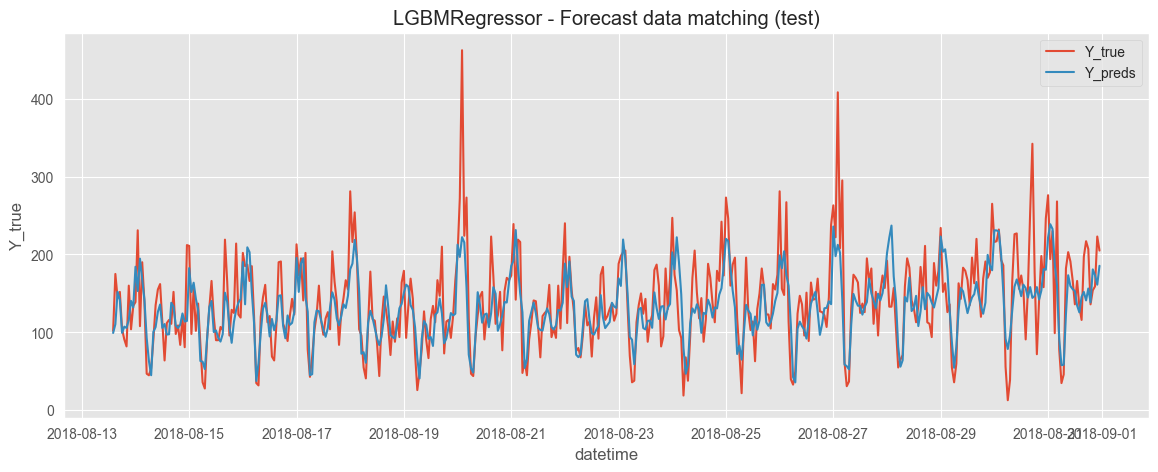

In [24]:
lgb_test_data = pd.DataFrame(
    {
        'Y_true': y_test,
        'Y_preds': lgb_test_preds
    }
)

plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(
    x=lgb_test_data.index, 
    y=lgb_test_data['Y_true'], 
    label='Y_true'
)
sns.lineplot(
    x=lgb_test_data.index, 
    y=lgb_test_data['Y_preds'], 
    label='Y_preds'
)
plt.title('LGBMRegressor - Forecast data matching (test)');

**Вывод:**

- На тестовой выборке результаты моделей значительно ухудшились
- Модели не смогли учесть выбросы, которые были характерны для тестового периода 

Лучшая модель на тесте:
- LGBMRegressor	- RMSE: 41.04

## Вывод

- Данные были загружены и обработны 
- Были добавлены признаки: lag, hour, dayofweek
- Наблюдается сезонность по дням, часам, а также растущий тренд
- Присутствуют выбросы, которые влияют на результаты моделей
- На тестовой выборке лучший результат у LGBMRegressor: 41.04
